In [33]:
from torch.utils import data # necessary to create a map-style dataset https://pytorch.org/docs/stable/data.html
from os.path import splitext, join
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import transforms
import code as cu # custom utils
from typing import Optional
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
import deprecation
from torch.nn import ModuleList
import matplotlib.pyplot as plt

dic = {
    0: 'empty',
    1: 'half',
    2: 'full'
}

Verifico che il dataset sia stato adattato correttamente

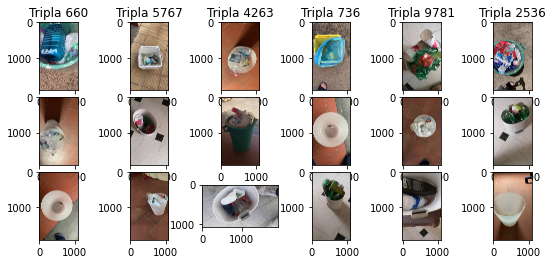

In [34]:
dst_triplet_df = pd.read_csv(join('dataset', 'all_labels_triplet.csv'))

plt.figure(figsize=(16,4))
for i, idx in enumerate(np.random.choice(len(dst_triplet_df), 6)):

    ax = plt.subplot(3,10,i+1)
    ax.set_title('Tripla {}'.format(idx))
    
    plt.subplot(3,10,i+1)
    plt.imshow(plt.imread(dst_triplet_df['anchor_image'][i]),cmap='gray')

    plt.subplot(3,10,i+11)
    plt.imshow(plt.imread(dst_triplet_df['pos_image'][i]),cmap='gray')

    plt.subplot(3,10,i+21)
    plt.imshow(plt.imread(dst_triplet_df['neg_image'][i]),cmap='gray')

plt.subplots_adjust(hspace=0.1)
plt.show()

Splitto il dataset in 3 file csv separati

In [35]:
from sklearn.model_selection import train_test_split

def split_train_val_test(dataset, perc):
    train, testval = train_test_split(dataset, test_size = perc[1]+perc[2])
    val, test = train_test_split(testval, test_size = perc[2]/(perc[1]+perc[2]))
    return train, val, test


In [36]:
def remove_unnamed_col(df):
    res = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
    return res

In [37]:
training_df, validation_df, test_df = split_train_val_test(dataset=dst_triplet_df, perc=[0.5, 0.2, 0.3])

training_df = remove_unnamed_col(training_df)
validation_df = remove_unnamed_col(validation_df)
test_df = remove_unnamed_col(test_df)

training_df.reset_index(drop=True, inplace=True)

validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

training_df.to_csv('dataset/triplet_training.csv')
validation_df.to_csv('dataset/triplet_validation.csv')
test_df.to_csv('dataset/triplet_test.csv')

In [38]:
class TripletTrashbinDataset(data.Dataset): # data.Dataset https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset
    def __init__(self, csv: str=None, transform: transforms=None):

        if csv is None:
            raise NotImplementedError("No default dataset is provided")
        if splitext(csv)[1] != '.csv':
            raise NotImplementedError("Only .csv files are supported")
        
        self.data = pd.read_csv(csv)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i=None):

        if i is None:
            raise NotImplementedError("Only int type is supported for get the item. None is not allowed")
        
        im_path_anchor, im_label_anchor = self.data.iloc[i]['anchor_image'], self.data.iloc[i].anchor_label
        im_anchor = Image.open(im_path_anchor)        # Handle image with Image module from Pillow https://pillow.readthedocs.io/en/stable/reference/Image.html
        if self.transform is not None:
            im_anchor = self.transform(im_anchor)

        im_path_pos, im_label_pos = self.data.iloc[i]['pos_image'], self.data.iloc[i].pos_label
        im_pos = Image.open(im_path_pos)
        if self.transform is not None:
            im_pos = self.transform(im_pos)

        im_path_neg, im_label_neg = self.data.iloc[i]['neg_image'], self.data.iloc[i].neg_label
        im_neg = Image.open(im_path_neg)
        if self.transform is not None:
            im_neg = self.transform(im_neg)

        return im_anchor, im_label_anchor, im_pos, im_label_pos, im_neg, im_label_neg

Testo che funzioni correttamente

In [39]:
data_img_size = 94
dst_triplet = TripletTrashbinDataset(csv=join('dataset', 'all_labels_triplet.csv'), transform=transforms.Compose([transforms.Resize(data_img_size), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))

In [41]:
dst_triplet.__getitem__(0)

(tensor([[[-1.4672, -1.4329, -1.4329,  ..., -0.6965, -0.9020, -0.7479],
          [-1.5185, -1.4672, -1.4500,  ...,  0.1083,  0.5022,  0.1083],
          [-1.5528, -1.5185, -1.5014,  ...,  0.8276,  0.8447,  0.3994],
          ...,
          [ 0.2453,  0.4337,  0.7591,  ...,  0.4508,  0.5364,  1.0159],
          [ 0.6563,  0.8789,  0.9817,  ..., -0.1143,  0.5022,  0.4337],
          [ 0.5022,  0.6734,  0.7762,  ..., -0.1828,  0.1597,  0.5536]],
 
         [[-0.1450, -0.1275, -0.1275,  ...,  0.2402,  0.1877,  0.2752],
          [-0.1975, -0.1625, -0.1450,  ...,  0.8004,  1.2031,  0.9755],
          [-0.2500, -0.2150, -0.1975,  ...,  1.3256,  1.4132,  1.1155],
          ...,
          [-0.1975,  0.0651,  0.2927,  ...,  0.1001,  0.1527,  0.5028],
          [ 0.2227,  0.4678,  0.5028,  ..., -0.4076,  0.2052,  0.0126],
          [ 0.0651,  0.2402,  0.2752,  ..., -0.4426, -0.0924,  0.1877]],
 
         [[-0.0441,  0.0082,  0.0082,  ...,  0.3219,  0.2173,  0.3219],
          [-0.0790, -0.0267,